# Paramètres <br/>
$D$ la demande du client <br/>
$PPA_t$ la production du PPA (de prix $p_{PPA} = 20 €/ MWh$) <br/>
$p_t$ le prix de l'éléricité sur le marché <br/>
$e_{bat}$ l'éfficité de la batterie <br/>
$c_{bat}$ la capacité de la batterie <br/>
$f_{bat}$ le flux maximal de la batterie <br/>
$e_{elec}$ l'éfficité de l'électrolyseur <br/>
$c_{elec}$ la capacit_é de l'électrolyseur <br/>
$c_{tank}$ la capacité du réservoir <br/>

# Variables <br/>
$\text{charge}_t$ la charge de la batterie à l'heure $t$ (en MWh)<br/>
$\text{prod}_t$ la production de l'électrolyseur à l'heure $t$ (en kg $H_2$)<br/>
$\text{stock}_t$ le stock d'hydrogène dans le reservoir à l'heure $t$ (en kg $H_2$)<br/>
$\text{elec}_t$ la consommation d'élécricité venant de la grille à l'heure $t$ (en MWh) <br/>
$\text{consPPA}_t$ la consommation d'élécricité venant du PPA à l'heure $t$ (en MWh) <br/>

# Contraintes <br/>

Satisfaction de la demande du client : <br/>
$\forall t \in [|1, T|], \text{prod}_t + \text{stock}_t = D_t + \text{stock}_{t+1}$ <br/>
Consomation d'élécricité : <br/>
$\forall t \in [|1, T|], \text{elec}_t + \text{consPPA}_t + e_{bat} \times \text{charge}_t = e_{elec} \times \text{prod}_t + \text{charge}_{t+1}$ <br/>
Contraintes de capacité : <br/>
$\forall t \in [|1, T|], \text{charge}_t \leq c_{bat}$ <br/>
$\forall t \in [|1, T|], \text{prod}_t \times e_{elec} \leq c_{elec} $ <br/>
$\forall t \in [|1, T|], \text{stock}_t \leq c_{tank} $ <br/>
$\forall t \in [|1, T|], \text{consPPA}_t \leq PPA_t $ <br/>
Contraintes de flux : <br/>
$\forall t \in [|1, T|], |\text{charge}_t - \text{charge}_{t+1}| \leq f_{bat} $ <br/>

# Objectif <br/>

Minimiser le coût de l'élécricité : <br/>
$\min \sum_{t=1}^{T} p_t \times \text{elec}_t + p_{PPA} \times \text{consPPA}_t$

In [54]:
from pulp import *
import matplotlib.pyplot as plt


In [55]:
D = 1000 # Kg of H2
PPA = [50] * 18 + [40, 30, 20, 10, 0, 50] # Mwh
PPPA = 20 # € / MWh
Pt = [20.79, 17.41, 16.24, 11.9, 9.77, 15.88, 24.88, 29.7, 35.01, 33.95, 29.9, 29.03] # € / MWh
Pt += [27.07, 26.43, 27.53, 29.05, 31.42, 39.92, 41.3, 41.51, 39.75, 30.13, 30.36, 32.4]

ebat = 0.9
cbat = 400 # MWh
fbat = 100 # MW

eelec = 0.050 # Mwh / Kg
celec = 1000 # MW

ctank = 500 # Kg


In [56]:
problem = LpProblem("H2", LpMinimize)
T = len(PPA) # Number of hours
indices = range(T) 
indicesExt = range(T+1) # Add the first hour of the next day (Final state)
# Variables
charge = LpVariable.dicts("charge", indicesExt, 0, None)
prod = LpVariable.dicts("prod", indices, 0, None)
stock = LpVariable.dicts("stock", indicesExt, 0, None)
elec = LpVariable.dicts("elec", indices, 0, None)
consPPA = LpVariable.dicts("consPPA", indices, 0, None)

In [57]:
#Constraints
T = len(PPA)
#Initial state
problem += charge[0] == 0
problem += stock[0] == 0

for t in range(T):
    # Electricity consumption
    problem += consPPA[t] + elec[t] + ebat * charge[t] == prod[t] * eelec + charge[t+1] 
    # Demand satisfaction
    problem += stock[t] + prod[t] == D + stock[t+1]
    # Flow constraints for the battery : |charge[t+1] - charge[t]| <= fbat
    problem += charge[t] - charge[t+1] <= fbat
    problem += charge[t+1] - charge[t] <= fbat
    # PPA constraints
    problem += consPPA[t] == PPA[t]
    problem += prod[t] * eelec <= celec

# We also need to respect those constraints for the final state
for t in range(T+1):
    # Capacity constraints for battery and tank
    problem += charge[t] <= cbat
    problem += stock[t] <= ctank


In [58]:
# Objective function
problem += lpSum([Pt[t] * elec[t] + PPPA * consPPA[t] for t in range(T)])

In [59]:
problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/nicolas/.local/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1e088006d16b42d588e6c2bdeabc7a4e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/1e088006d16b42d588e6c2bdeabc7a4e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 201 COLUMNS
At line 638 RHS
At line 835 BOUNDS
At line 836 ENDATA
Problem MODEL has 196 rows, 122 columns and 388 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 68 (-128) rows, 69 (-53) columns and 203 (-185) elements
0  Obj 21000 Primal inf 150 (5)
32  Obj 21000 Primal inf 3879.5712 (13)
43  Obj 25343.351
Optimal - objective value 25343.351
After Postsolve, objective 25343.351, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 25343.35123 - 43 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to al

1

In [60]:
prod_out = [value(prod[t]) for t in range(T)]
elec_out = [value(elec[t]) for t in range(T)]
charge_out = [value(charge[t]) for t in range(T+1)]
stock_out = [value(stock[t]) for t in range(T+1)]
consPPA_out = [value(consPPA[t]) for t in range(T)]

Text(0.5, 1.0, 'H2 production and stock, constant demand of 1000 Kg')

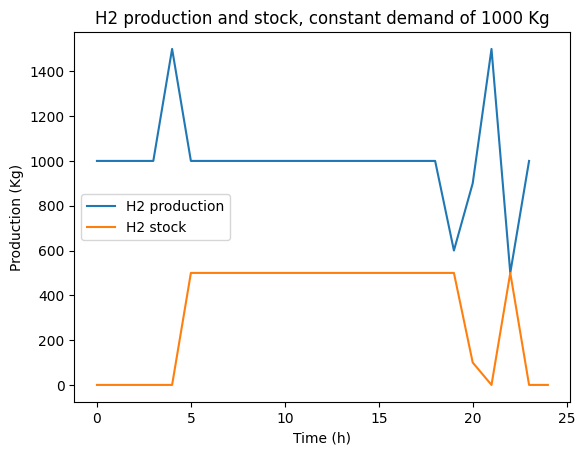

In [61]:
# Plot the production
fig, ax = plt.subplots()

ax.plot(range(T), prod_out, label = "H2 production")
ax.plot(range(T+1), stock_out, label = "H2 stock")
ax.legend()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Production (Kg)")
ax.set_title(f"H2 production and stock, constant demand of {D} Kg")

Text(0.5, 1.0, 'Prices')

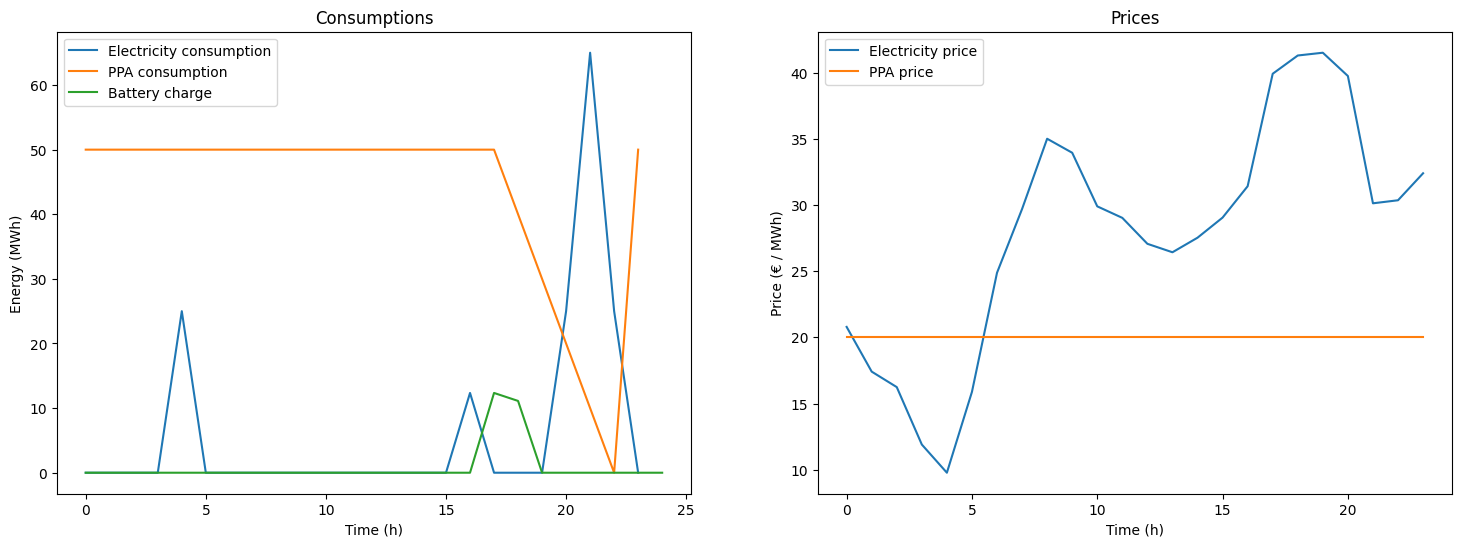

In [62]:
fig = plt.figure(figsize = (18, 6))
# Plot the consumptions
ax = fig.add_subplot(121)
ax.plot(range(T), elec_out, label="Electricity consumption")
ax.plot(range(T), consPPA_out, label="PPA consumption")
ax.plot(range(T+1), charge_out, label="Battery charge")
ax.legend()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Energy (MWh)")
ax.set_title("Consumptions")
# Plot the prices
ax2 = fig.add_subplot(122)
ax2.plot(range(T), Pt, label="Electricity price")
ax2.plot(range(T), [PPPA] * T, label="PPA price")
ax2.legend()
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Price (€ / MWh)")
ax2.set_title("Prices")

